# Proyecto Redes Neuronales: Transformer Encoder (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo Transformer Encoder usando PyTorch  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  


## 0. Configuracion de Parametros Globales

In [1]:
# Configuracion del experimento
from datetime import datetime as dt
EXPERIMENT_TIMESTAMP = dt.now().strftime("%Y%m%d_%H%M%S")

EXPERIMENT_NAME = "Transformer_PyTorch"
MODEL_TYPE = "Transformer_Torch"
MODEL_SAVE_NAME = f"{MODEL_TYPE}_{EXPERIMENT_TIMESTAMP}"
RANDOM_SEED = 42
PROJECT_PART = "project_part_4"

# Directorios
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"
USE_TITLE_AND_BODY = True

# Tokenizacion
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 200

# Arquitectura del Transformer
EMBEDDING_DIM = 256  
NUM_HEADS = 8  
NUM_LAYERS = 4  
DIM_FEEDFORWARD = 512  
DROPOUT_RATE = 0.1
POOLING = 'cls'

# Entrenamiento
EPOCHS = 60
BATCH_SIZE = 32
LEARNING_RATE = 1e-4  
PATIENCE = 5  
WEIGHT_DECAY = 1e-4
CLIP_GRAD_NORM = 1.0
USE_CLASS_WEIGHTS = True
WARMUP_STEPS = 1000 

print(f"=== Configuracion: {EXPERIMENT_NAME} ===")
print(f"Nombre del modelo: {MODEL_SAVE_NAME}")
print(f"Arquitectura: D={EMBEDDING_DIM}, Heads={NUM_HEADS}, Layers={NUM_LAYERS}, FF={DIM_FEEDFORWARD}")
print(f"Entrenamiento: LR={LEARNING_RATE}, Batch={BATCH_SIZE}, Patience={PATIENCE}")
print(f"GPU: RTX 5070 12GB - Configuracion optimizada")
print("="*60)


=== Configuracion: Transformer_PyTorch ===
Nombre del modelo: Transformer_Torch_20251130_171248
Arquitectura: D=256, Heads=8, Layers=4, FF=512
Entrenamiento: LR=0.0001, Batch=32, Patience=5
GPU: RTX 5070 12GB - Configuracion optimizada


## 1. Importacion de Librerias

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import TransformerClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070


## 2. Carga y Preprocesamiento de Datos

In [3]:
print("=== Cargando datos ===")

# Inicializar DataLoader
data_loader = DataLoaderTorch(data_dir=DATA_DIR)

# Cargar datasets
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nTamanos de conjuntos:")
print(f"  Entrenamiento: {len(train_df):,}")
print(f"  Validacion: {len(val_df):,}")
print(f"  Prueba: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE:
    if LANGUAGE_COLUMN in train_df.columns:
        print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
        train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        print(f"Tamanos despues de filtrar:")
        print(f"  Entrenamiento: {len(train_df):,}")
        print(f"  Validacion: {len(val_df):,}")
        print(f"  Prueba: {len(test_df):,}")

# Verificar distribucion de clases
if TARGET_COLUMN in train_df.columns:
    print(f"\nDistribucion de clases (entrenamiento):")
    for i in range(1, 6):
        count = len(train_df[train_df[TARGET_COLUMN] == i])
        print(f"  Clase {i} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

=== Cargando datos ===
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamanos de conjuntos:
  Entrenamiento: 1,200,000
  Validacion: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamanos de conjuntos:
  Entrenamiento: 1,200,000
  Validacion: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Tamanos despues de filtrar:
  Entrenamiento: 200,000
  Validacion: 5,000
  Prueba: 5,000

Distribucion de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20.0%)
  Clase 3 estrellas: 40,000 (20.0%)
  Clase 4 estrellas: 40,000 (20.0%)
  Clase 5 estrellas: 40,000 (20.0%)
Tamanos despues de filtrar:
  Entrenamiento: 200,000
  Validacion: 5,000
  Prueba: 5,000

Distribucion de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20

## 3. Preprocesamiento y Creacion de DataLoaders

Esta celda realiza:
- Tokenizacion de textos
- Construccion de vocabulario
- Conversion a secuencias numericas
- Padding de secuencias
- Creacion de DataLoaders de PyTorch

In [4]:
print("=== Preprocesando datos para embeddings ===")

# Preprocesar datos usando el metodo de embedding
preprocessing_result = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer resultados
train_loader = preprocessing_result['train_loader']
val_loader = preprocessing_result['val_loader']
test_loader = preprocessing_result['test_loader']
num_classes = preprocessing_result['num_classes']
vocab_size = preprocessing_result['vocab_size']
pad_idx = 0  # Keras siempre usa 0 como padding index

print(f"\nVocabulario construido:")
print(f"  Tamano del vocabulario: {vocab_size:,}")
print(f"  Indice de padding: {pad_idx}")
print(f"  Numero de clases: {num_classes}")
print(f"  Max length: {MAX_LENGTH}")

print(f"\nDataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Ejemplo de un batch
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Forma de secuencias: {sample_batch[0].shape}")
print(f"  Forma de labels: {sample_batch[1].shape}")

=== Preprocesando datos para embeddings ===
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamano del vocabulario: 48,283
  Indice de padding: 0
  Numero de clases: 5
  Max length: 200

DataLoaders creados:
  Train batches: 6250
  Val batches: 157
  Test batches: 157

Ejemplo de batch:
  Forma de secuencias: torch.Size([32, 200])
  Forma de labels: torch.Size([32])
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamano del vocabulario: 48,2

## 4. Construccion del Modelo Transformer

In [5]:
print("=== Construyendo modelo Transformer Encoder ===")

# Verificar que EMBEDDING_DIM sea divisible por NUM_HEADS
assert EMBEDDING_DIM % NUM_HEADS == 0, f"EMBEDDING_DIM ({EMBEDDING_DIM}) debe ser divisible por NUM_HEADS ({NUM_HEADS})"

# Crear modelo
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    num_classes=num_classes,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout_rate=DROPOUT_RATE,
    max_length=MAX_LENGTH,
    padding_idx=pad_idx,
    pooling=POOLING
)

print(f"\nArquitectura del modelo:")
print(model)

# Contar parametros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParametros totales: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")

=== Construyendo modelo Transformer Encoder ===

Arquitectura del modelo:
TransformerClassifier(
  (embedding): Embedding(48284, 256, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((256,), eps=1e-05, ele

## 5. Configuracion del Entrenamiento

In [6]:
print("=== Configurando entrenamiento ===")

# Calcular class weights para manejar desbalanceo
y_train_np = preprocessing_result['y_train'].numpy()
class_counts = np.bincount(y_train_np)
total_samples = len(y_train_np)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights) if USE_CLASS_WEIGHTS else None

print(f"Distribucion de clases:")
for i, count in enumerate(class_counts):
    weight_str = f"weight: {class_weights[i]:.4f}" if USE_CLASS_WEIGHTS else "weight: 1.0"
    print(f"  Clase {i+1}: {count:,} muestras, {weight_str}")

# Funcion de perdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None
)

# Optimizador AdamW (mejor para Transformers)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Scheduler con warmup
total_steps = len(train_loader) * EPOCHS

def lr_lambda(current_step):
    if current_step < WARMUP_STEPS:
        return float(current_step) / float(max(1, WARMUP_STEPS))
    return max(0.1, float(total_steps - current_step) / float(max(1, total_steps - WARMUP_STEPS)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"\nOptimizador: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: Linear warmup ({WARMUP_STEPS} steps) + Linear decay")
print(f"Total steps: {total_steps}")

=== Configurando entrenamiento ===
Distribucion de clases:
  Clase 1: 40,000 muestras, weight: 1.0000
  Clase 2: 40,000 muestras, weight: 1.0000
  Clase 3: 40,000 muestras, weight: 1.0000
  Clase 4: 40,000 muestras, weight: 1.0000
  Clase 5: 40,000 muestras, weight: 1.0000

Optimizador: AdamW (lr=0.0001, weight_decay=0.0001)
Scheduler: Linear warmup (1000 steps) + Linear decay
Total steps: 375000


## 6. Entrenamiento del Modelo

In [7]:
print("=== Iniciando entrenamiento ===")

# Inicializar trainer
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

# Entrenar modelo con nombre unico
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=MODEL_SAVE_NAME,
    scheduler=scheduler,
    clip_grad_norm=CLIP_GRAD_NORM,
    verbose=True
)

print(f"\n=== Entrenamiento completado ===")
print(f"Epocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo total: {training_results['training_time']:.2f}s")
print(f"Mejor Val Loss: {training_results['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {training_results['best_val_accuracy']:.4f}")

=== Iniciando entrenamiento ===
Usando dispositivo: cuda

Entrenando Transformer_Torch_20251130_171248...
Parámetros totales: 14,470,917
Parámetros entrenables: 14,470,917
Gradient clipping activado: max_norm=1.0


Epoch 1/60 [Train]:   0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 1/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 183.18it/s, loss=3.9421, acc=20.52%]



Epoch 1/60:
  Train Loss: 2.2929, Train Acc: 0.2024, Train F1-Macro: 0.1404
  Val Loss: 2.1760, Val Acc: 0.2052, Val F1-Macro: 0.1244
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.1244)


Epoch 2/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 183.56it/s, loss=1.5509, acc=23.38%]



Epoch 2/60:
  Train Loss: 1.8364, Train Acc: 0.2075, Train F1-Macro: 0.2064
  Val Loss: 1.6153, Val Acc: 0.2338, Val F1-Macro: 0.2008
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.2008)


Epoch 3/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 188.17it/s, loss=1.4297, acc=27.52%]



Epoch 3/60:
  Train Loss: 1.7394, Train Acc: 0.2225, Train F1-Macro: 0.2224
  Val Loss: 1.5656, Val Acc: 0.2752, Val F1-Macro: 0.2521
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.2521)


Epoch 4/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 187.65it/s, loss=1.3603, acc=33.74%]



Epoch 4/60:
  Train Loss: 1.6824, Train Acc: 0.2436, Train F1-Macro: 0.2435
  Val Loss: 1.5099, Val Acc: 0.3374, Val F1-Macro: 0.3230
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val F1-Macro: 0.3230)


Epoch 5/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 184.59it/s, loss=1.1477, acc=40.48%]



Epoch 5/60:
  Train Loss: 1.6072, Train Acc: 0.2814, Train F1-Macro: 0.2811
  Val Loss: 1.4108, Val Acc: 0.4048, Val F1-Macro: 0.3807
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.3807)


Epoch 6/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 193.85it/s, loss=0.8848, acc=46.08%]



Epoch 6/60:
  Train Loss: 1.4858, Train Acc: 0.3423, Train F1-Macro: 0.3407
  Val Loss: 1.2690, Val Acc: 0.4608, Val F1-Macro: 0.4445
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4445)


Epoch 7/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 183.96it/s, loss=0.7715, acc=49.34%]



Epoch 7/60:
  Train Loss: 1.3606, Train Acc: 0.4052, Train F1-Macro: 0.4030
  Val Loss: 1.1823, Val Acc: 0.4934, Val F1-Macro: 0.4813
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4813)


Epoch 8/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 189.71it/s, loss=0.6867, acc=51.12%]



Epoch 8/60:
  Train Loss: 1.2712, Train Acc: 0.4496, Train F1-Macro: 0.4473
  Val Loss: 1.1296, Val Acc: 0.5112, Val F1-Macro: 0.4975
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.4975)


Epoch 9/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 188.60it/s, loss=0.6720, acc=52.10%]



Epoch 9/60:
  Train Loss: 1.2086, Train Acc: 0.4763, Train F1-Macro: 0.4736
  Val Loss: 1.0908, Val Acc: 0.5210, Val F1-Macro: 0.5104
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5104)


Epoch 10/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 189.88it/s, loss=0.5866, acc=53.34%]



Epoch 10/60:
  Train Loss: 1.1565, Train Acc: 0.4984, Train F1-Macro: 0.4954
  Val Loss: 1.0636, Val Acc: 0.5334, Val F1-Macro: 0.5194
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5194)


Epoch 11/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 192.73it/s, loss=0.6113, acc=54.30%]



Epoch 11/60:
  Train Loss: 1.1200, Train Acc: 0.5134, Train F1-Macro: 0.5102
  Val Loss: 1.0414, Val Acc: 0.5430, Val F1-Macro: 0.5327
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5327)


Epoch 12/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 186.62it/s, loss=0.5822, acc=55.14%]



Epoch 12/60:
  Train Loss: 1.0886, Train Acc: 0.5253, Train F1-Macro: 0.5219
  Val Loss: 1.0242, Val Acc: 0.5514, Val F1-Macro: 0.5404
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5404)


Epoch 13/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 192.77it/s, loss=0.5740, acc=55.54%]



Epoch 13/60:
  Train Loss: 1.0622, Train Acc: 0.5359, Train F1-Macro: 0.5323
  Val Loss: 1.0033, Val Acc: 0.5554, Val F1-Macro: 0.5451
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5451)


Epoch 14/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 194.93it/s, loss=0.5603, acc=55.72%]



Epoch 14/60:
  Train Loss: 1.0389, Train Acc: 0.5466, Train F1-Macro: 0.5431
  Val Loss: 0.9953, Val Acc: 0.5572, Val F1-Macro: 0.5485
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5485)


Epoch 15/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 195.87it/s, loss=0.5854, acc=56.50%]



Epoch 15/60:
  Train Loss: 1.0185, Train Acc: 0.5555, Train F1-Macro: 0.5518
  Val Loss: 0.9819, Val Acc: 0.5650, Val F1-Macro: 0.5577
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5577)


Epoch 16/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.35it/s, loss=0.5604, acc=56.96%]



Epoch 16/60:
  Train Loss: 1.0036, Train Acc: 0.5607, Train F1-Macro: 0.5573
  Val Loss: 0.9701, Val Acc: 0.5696, Val F1-Macro: 0.5618
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5618)


Epoch 17/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.18it/s, loss=0.5384, acc=57.08%]



Epoch 17/60:
  Train Loss: 0.9888, Train Acc: 0.5684, Train F1-Macro: 0.5651
  Val Loss: 0.9657, Val Acc: 0.5708, Val F1-Macro: 0.5632
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5632)


Epoch 18/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 178.27it/s, loss=0.5531, acc=57.46%]



Epoch 18/60:
  Train Loss: 0.9749, Train Acc: 0.5738, Train F1-Macro: 0.5705
  Val Loss: 0.9561, Val Acc: 0.5746, Val F1-Macro: 0.5695
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5695)


Epoch 19/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.35it/s, loss=0.4300, acc=57.96%]



Epoch 19/60:
  Train Loss: 0.9638, Train Acc: 0.5793, Train F1-Macro: 0.5760
  Val Loss: 0.9581, Val Acc: 0.5796, Val F1-Macro: 0.5701
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5701)


Epoch 20/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.43it/s, loss=0.5178, acc=58.22%]



Epoch 20/60:
  Train Loss: 0.9522, Train Acc: 0.5825, Train F1-Macro: 0.5794
  Val Loss: 0.9482, Val Acc: 0.5822, Val F1-Macro: 0.5738
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5738)


Epoch 21/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.02it/s, loss=0.5395, acc=59.16%]



Epoch 21/60:
  Train Loss: 0.9432, Train Acc: 0.5883, Train F1-Macro: 0.5852
  Val Loss: 0.9412, Val Acc: 0.5916, Val F1-Macro: 0.5858
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5858)


Epoch 22/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 184.74it/s, loss=0.5424, acc=59.00%]



Epoch 22/60:
  Train Loss: 0.9325, Train Acc: 0.5937, Train F1-Macro: 0.5907
  Val Loss: 0.9388, Val Acc: 0.5900, Val F1-Macro: 0.5867
  Learning Rate: 0.000002
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5867)


Epoch 23/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 195.68it/s, loss=0.5392, acc=58.96%]



Epoch 23/60:
  Train Loss: 0.9256, Train Acc: 0.5968, Train F1-Macro: 0.5940
  Val Loss: 0.9362, Val Acc: 0.5896, Val F1-Macro: 0.5847
  Learning Rate: 0.000002
  Épocas sin mejora: 1/5


Epoch 24/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 197.19it/s, loss=0.5895, acc=58.68%]



Epoch 24/60:
  Train Loss: 0.9178, Train Acc: 0.5998, Train F1-Macro: 0.5971
  Val Loss: 0.9346, Val Acc: 0.5868, Val F1-Macro: 0.5803
  Learning Rate: 0.000002
  Épocas sin mejora: 2/5


Epoch 25/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 194.40it/s, loss=0.4303, acc=59.34%]



Epoch 25/60:
  Train Loss: 0.9101, Train Acc: 0.6039, Train F1-Macro: 0.6012
  Val Loss: 0.9438, Val Acc: 0.5934, Val F1-Macro: 0.5846
  Learning Rate: 0.000003
  Épocas sin mejora: 3/5


Epoch 26/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.42it/s, loss=0.5493, acc=59.42%]



Epoch 26/60:
  Train Loss: 0.9021, Train Acc: 0.6083, Train F1-Macro: 0.6057
  Val Loss: 0.9319, Val Acc: 0.5942, Val F1-Macro: 0.5890
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5890)


Epoch 27/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.66it/s, loss=0.5326, acc=59.52%]



Epoch 27/60:
  Train Loss: 0.8966, Train Acc: 0.6119, Train F1-Macro: 0.6094
  Val Loss: 0.9295, Val Acc: 0.5952, Val F1-Macro: 0.5882
  Learning Rate: 0.000003
  Épocas sin mejora: 1/5


Epoch 28/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 193.26it/s, loss=0.5490, acc=59.50%]



Epoch 28/60:
  Train Loss: 0.8906, Train Acc: 0.6145, Train F1-Macro: 0.6120
  Val Loss: 0.9293, Val Acc: 0.5950, Val F1-Macro: 0.5887
  Learning Rate: 0.000003
  Épocas sin mejora: 2/5


Epoch 29/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 189.17it/s, loss=0.6154, acc=59.82%]



Epoch 29/60:
  Train Loss: 0.8850, Train Acc: 0.6174, Train F1-Macro: 0.6150
  Val Loss: 0.9281, Val Acc: 0.5982, Val F1-Macro: 0.5931
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5931)


Epoch 30/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 194.61it/s, loss=0.4937, acc=59.82%]



Epoch 30/60:
  Train Loss: 0.8779, Train Acc: 0.6219, Train F1-Macro: 0.6196
  Val Loss: 0.9276, Val Acc: 0.5982, Val F1-Macro: 0.5934
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5934)


Epoch 31/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 194.58it/s, loss=0.4260, acc=59.98%]



Epoch 31/60:
  Train Loss: 0.8720, Train Acc: 0.6240, Train F1-Macro: 0.6218
  Val Loss: 0.9327, Val Acc: 0.5998, Val F1-Macro: 0.5925
  Learning Rate: 0.000003
  Épocas sin mejora: 1/5


Epoch 32/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 173.21it/s, loss=0.4688, acc=59.88%]



Epoch 32/60:
  Train Loss: 0.8667, Train Acc: 0.6261, Train F1-Macro: 0.6239
  Val Loss: 0.9312, Val Acc: 0.5988, Val F1-Macro: 0.5964
  Learning Rate: 0.000003
  ✓ Mejor modelo guardado (Val F1-Macro: 0.5964)


Epoch 33/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 187.14it/s, loss=0.5036, acc=60.00%]



Epoch 33/60:
  Train Loss: 0.8611, Train Acc: 0.6301, Train F1-Macro: 0.6281
  Val Loss: 0.9292, Val Acc: 0.6000, Val F1-Macro: 0.5951
  Learning Rate: 0.000003
  Épocas sin mejora: 1/5


Epoch 34/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.35it/s, loss=0.5689, acc=59.80%]



Epoch 34/60:
  Train Loss: 0.8553, Train Acc: 0.6318, Train F1-Macro: 0.6297
  Val Loss: 0.9359, Val Acc: 0.5980, Val F1-Macro: 0.5921
  Learning Rate: 0.000003
  Épocas sin mejora: 2/5


Epoch 35/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.94it/s, loss=0.5537, acc=60.08%]



Epoch 35/60:
  Train Loss: 0.8507, Train Acc: 0.6363, Train F1-Macro: 0.6343
  Val Loss: 0.9358, Val Acc: 0.6008, Val F1-Macro: 0.6008
  Learning Rate: 0.000004
  ✓ Mejor modelo guardado (Val F1-Macro: 0.6008)


Epoch 36/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.94it/s, loss=0.6198, acc=60.28%]



Epoch 36/60:
  Train Loss: 0.8452, Train Acc: 0.6374, Train F1-Macro: 0.6355
  Val Loss: 0.9339, Val Acc: 0.6028, Val F1-Macro: 0.5978
  Learning Rate: 0.000004
  Épocas sin mejora: 1/5


Epoch 37/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 190.56it/s, loss=0.5364, acc=60.18%]



Epoch 37/60:
  Train Loss: 0.8401, Train Acc: 0.6410, Train F1-Macro: 0.6391
  Val Loss: 0.9335, Val Acc: 0.6018, Val F1-Macro: 0.5963
  Learning Rate: 0.000004
  Épocas sin mejora: 2/5


Epoch 38/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 191.52it/s, loss=0.5057, acc=60.50%]



Epoch 38/60:
  Train Loss: 0.8340, Train Acc: 0.6440, Train F1-Macro: 0.6422
  Val Loss: 0.9382, Val Acc: 0.6050, Val F1-Macro: 0.5997
  Learning Rate: 0.000004
  Épocas sin mejora: 3/5


Epoch 39/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 184.51it/s, loss=0.4905, acc=60.28%]



Epoch 39/60:
  Train Loss: 0.8276, Train Acc: 0.6483, Train F1-Macro: 0.6465
  Val Loss: 0.9365, Val Acc: 0.6028, Val F1-Macro: 0.5979
  Learning Rate: 0.000004
  Épocas sin mejora: 4/5


Epoch 40/60 [Val]: 100%|██████████| 157/157 [00:00<00:00, 194.75it/s, loss=0.5669, acc=60.06%]



Epoch 40/60:
  Train Loss: 0.8223, Train Acc: 0.6515, Train F1-Macro: 0.6498
  Val Loss: 0.9441, Val Acc: 0.6006, Val F1-Macro: 0.5988
  Learning Rate: 0.000004
  Épocas sin mejora: 5/5

Early stopping en época 40

Mejor modelo restaurado
Modelo guardado en: models/project_part_4/Transformer_Torch_20251130_171248.pth

=== Entrenamiento completado ===
Epocas entrenadas: 40
Tiempo total: 5098.76s
Mejor Val Loss: 0.9358
Mejor Val Accuracy: 0.6008


## 7. Evaluacion en Conjunto de Prueba

In [8]:
print("=== Evaluando en conjunto de prueba ===")

# Evaluar modelo
test_results = trainer.evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion
)

print(f"\n=== Resultados en Test ===")
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.4f}")

# Reporte de clasificacion
print("\nReporte de clasificacion:")
print(classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1} estrellas" for i in range(num_classes)],
    digits=4
))

=== Evaluando en conjunto de prueba ===

Evaluando modelo en conjunto de prueba...


Evaluando: 100%|██████████| 157/157 [00:00<00:00, 213.15it/s]

Test Loss: 0.9625
Test Accuracy: 0.6096
Test F1-Macro: 0.6071

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1000
           1       0.52      0.56      0.54      1000
           2       0.51      0.48      0.49      1000
           3       0.60      0.51      0.55      1000
           4       0.72      0.79      0.75      1000

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000


=== Resultados en Test ===
Test Loss: 0.9625
Test Accuracy: 0.6096

Reporte de clasificacion:
              precision    recall  f1-score   support

 1 estrellas     0.6902    0.7130    0.7014      1000
 2 estrellas     0.5166    0.5600    0.5374      1000
 3 estrellas     0.5074    0.4770    0.4918      1000
 4 estrellas     0.5981    0.5120    0.5517      1000
 5 estrellas     0.7231    0.7860    0.7532      1000

    

## 8. Visualizacion de Resultados

=== Generando visualizaciones ===
Gráfico de historial de entrenamiento guardado en: output/project_part_4/Transformer_Torch_history.png


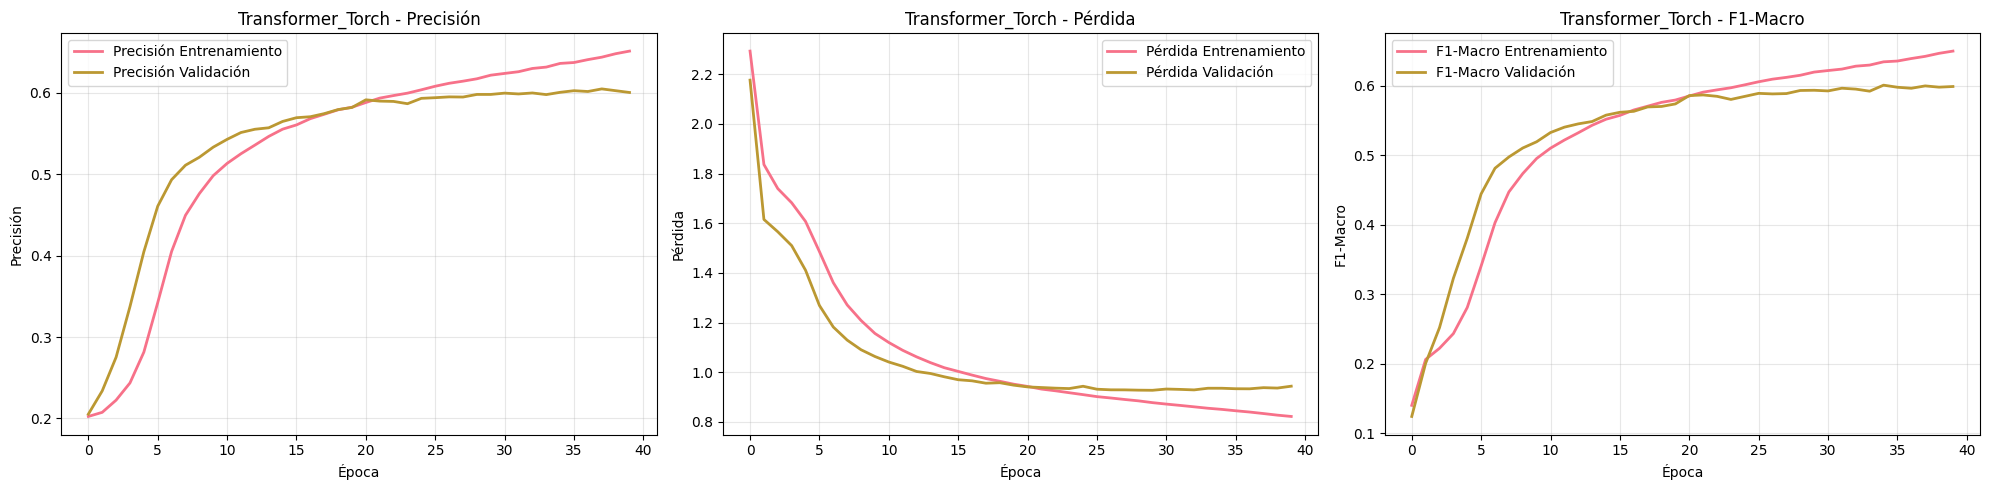

Matriz de confusión guardada en: output/project_part_4/Transformer_Torch_confusion_matrix.png


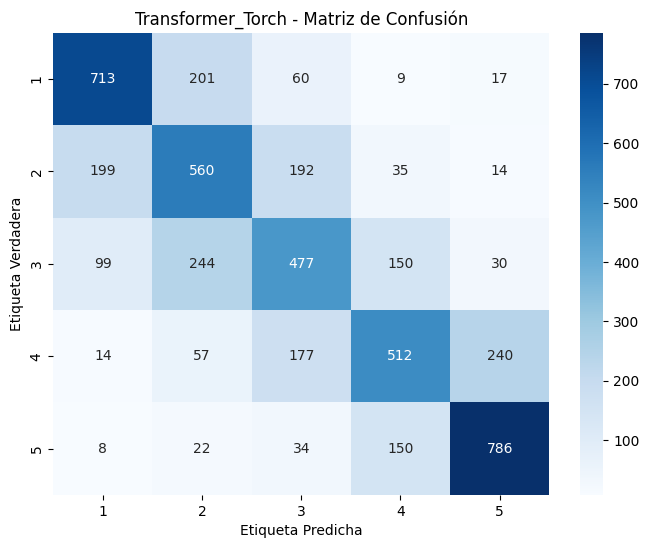

Visualizaciones guardadas en: output/project_part_4


In [9]:
print("=== Generando visualizaciones ===")

# Historia de entrenamiento
history = training_results['history']

# Graficar historia de entrenamiento (perdida y accuracy)
Visualizer.plot_training_history(
    history=history,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_history.png'),
    framework='pytorch'
)

# Matriz de confusion
Visualizer.plot_confusion_matrix(
    y_true=test_results['labels'],
    y_pred=test_results['predictions'],
    class_names=[f"{i+1}" for i in range(num_classes)],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_confusion_matrix.png')
)

print("Visualizaciones guardadas en:", OUTPUT_DIR)

## 9. Guardado de Resultados del Experimento

In [10]:
print("=== Guardando resultados del experimento ===")

# Reporte de clasificacion
from sklearn.metrics import classification_report as sklearn_classification_report
classification_rep = sklearn_classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1}" for i in range(num_classes)],
    output_dict=True
)

# Guardar componentes con nombre unico (tokenizer, label_encoder, etc)
save_model_components_torch(
    model_name=MODEL_SAVE_NAME,
    model=model,
    tokenizer=data_loader.tokenizer,
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

# Corregir model_path en training_results para que coincida con el nombre guardado
training_results['model_path'] = f"{MODEL_DIR}/{MODEL_SAVE_NAME}.pth"

# Preparar datos del experimento
experiment_data = {
    'experiment_name': f"{EXPERIMENT_NAME}_{EXPERIMENT_TIMESTAMP}",
    'configuration': {
        'model_type': MODEL_TYPE,
        'model_save_name': MODEL_SAVE_NAME,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'num_heads': NUM_HEADS,
        'num_layers': NUM_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout_rate': DROPOUT_RATE,
        'pooling': POOLING,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'clip_grad_norm': CLIP_GRAD_NORM,
        'warmup_steps': WARMUP_STEPS,
        'patience': PATIENCE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'use_title_and_body': USE_TITLE_AND_BODY
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_results['test_accuracy'],
        'test_loss': test_results['test_loss'],
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar experimento
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Modelo guardado en: {MODEL_DIR}/{MODEL_SAVE_NAME}.pth")

=== Guardando resultados del experimento ===
Modelo guardado: models/project_part_4/Transformer_Torch_20251130_171248.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 256, 'num_classes': 5, 'num_heads': 8, 'num_layers': 4, 'dim_feedforward': 512, 'dropout_rate': 0.1, 'max_length': 200, 'pooling': 'cls'}
Tokenizer guardado: models/project_part_4/Transformer_Torch_20251130_171248_tokenizer.pkl
Label encoder guardado: models/project_part_4/Transformer_Torch_20251130_171248_label_encoder.pkl
Componentes guardados en models/project_part_4/
Experiment 5 (Transformer_PyTorch_20251130_171248) saved to output/project_part_4/experiment_history.json

Experimento #5 guardado
Modelo guardado en: models/project_part_4/Transformer_Torch_20251130_171248.pth
